In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(".."))

Plot some time series of how the number of events changes over time.

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import lzma, datetime
import impute.chicago
import open_cp.geometry

In [41]:
#datadir = os.path.join("/media", "disk", "Data")
datadir = os.path.join("..", "..", "..", "..", "Data")

def gen():
    filename = os.path.join(datadir, "chicago_all.csv.xz")
    with lzma.open(filename, "rt", encoding="utf8") as f:
        yield from impute.chicago.load_only_with_point(f)
        
next(gen())

Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.531655723, 41.698387427))

In [6]:
set(row.crime_type for row in gen())

{'ARSON',
 'ASSAULT',
 'BATTERY',
 'BURGLARY',
 'CONCEALED CARRY LICENSE VIOLATION',
 'CRIM SEXUAL ASSAULT',
 'CRIMINAL DAMAGE',
 'CRIMINAL TRESPASS',
 'DECEPTIVE PRACTICE',
 'DOMESTIC VIOLENCE',
 'GAMBLING',
 'HOMICIDE',
 'HUMAN TRAFFICKING',
 'INTERFERENCE WITH PUBLIC OFFICER',
 'INTIMIDATION',
 'KIDNAPPING',
 'LIQUOR LAW VIOLATION',
 'MOTOR VEHICLE THEFT',
 'NARCOTICS',
 'NON - CRIMINAL',
 'NON-CRIMINAL',
 'NON-CRIMINAL (SUBJECT SPECIFIED)',
 'OBSCENITY',
 'OFFENSE INVOLVING CHILDREN',
 'OTHER NARCOTIC VIOLATION',
 'OTHER OFFENSE',
 'PROSTITUTION',
 'PUBLIC INDECENCY',
 'PUBLIC PEACE VIOLATION',
 'RITUALISM',
 'ROBBERY',
 'SEX OFFENSE',
 'STALKING',
 'THEFT',
 'WEAPONS VIOLATION'}

In [7]:
data = [row for row in gen() if row.crime_type == "BURGLARY"]

### Count of events per week

In [30]:
start = min(row.datetime for row in data)
start = start.date()
print(start, start.isoweekday())
start = datetime.datetime.fromordinal(start.toordinal())
# Apparently January 1st 2001 was a Monday.

2001-01-01 1


In [31]:
end_date = max(row.datetime for row in data).date()
end_date = datetime.datetime.fromordinal(end_date.toordinal())

In [32]:
length = datetime.timedelta(days=7)
counts = {}
while True:
    end = start + length
    if end >= end_date:
        break
    counts[start] = sum(row.datetime >= start and row.datetime < end for row in data)
    start = end

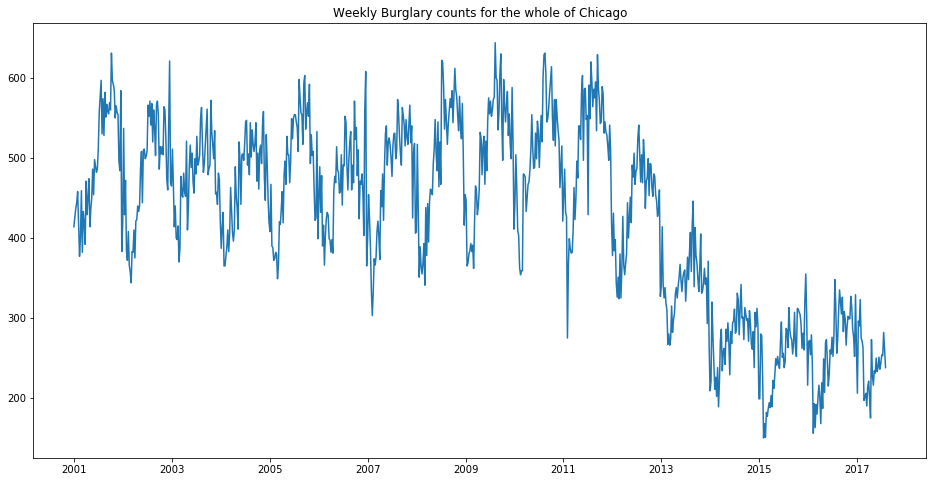

In [38]:
fig, ax = plt.subplots(figsize=(16,8))

x = list(counts)
x.sort()
y = [counts[t] for t in x]
ax.plot(x, y)
ax.set_title("Weekly Burglary counts for the whole of Chicago")
None

## By region

In [44]:
import open_cp.sources.chicago
open_cp.sources.chicago.set_data_directory(datadir)

sides = {"Far North", "Northwest", "North", "West", "Central",
    "South", "Southwest", "Far Southwest", "Far Southeast"}

In [79]:
proj = impute.chicago.projector()
coords = np.asarray([row.point for row in data])
xcs, ycs = proj(*coords.T)
ts = [row.datetime for row in data]
timed_points = open_cp.data.TimedPoints.from_coords(ts, xcs, ycs)

In [82]:
by_side = {}
for side in sides:
    geo = open_cp.sources.chicago.get_side(side)
    by_side[side] = open_cp.geometry.intersect_timed_points(timed_points, geo)

In [84]:
start_date = min(row.datetime for row in data).date()
start_date = datetime.datetime.fromordinal(start_date.toordinal())
end_date = max(row.datetime for row in data).date()
end_date = datetime.datetime.fromordinal(end_date.toordinal())

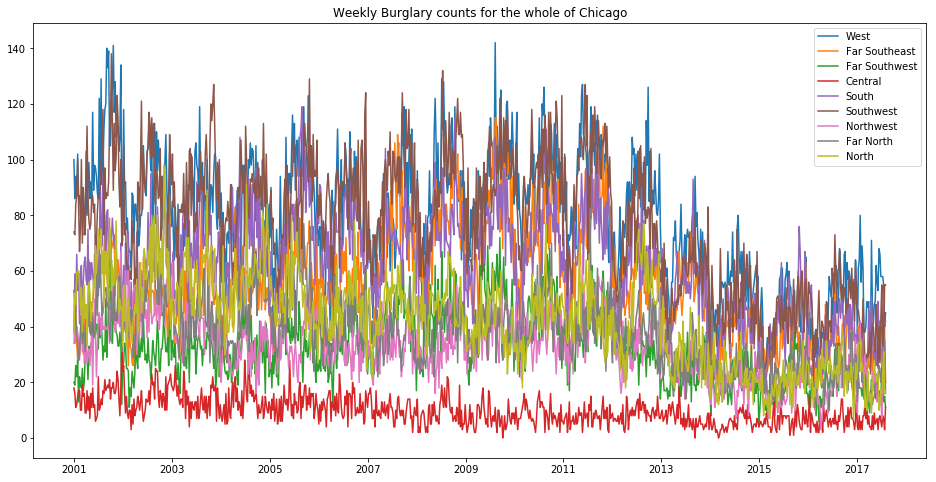

In [86]:
fig, ax = plt.subplots(figsize=(16,8))

for side in by_side:
    counts = {}
    start = start_date
    while True:
        end = start + length
        if end >= end_date:
            break
        counts[start] = sum(ts >= start and ts < end for ts in by_side[side].times_datetime())
        start = end
    x = list(counts)
    x.sort()
    y = [counts[t] for t in x]
    ax.plot(x, y, label=side)
ax.set_title("Weekly Burglary counts for the whole of Chicago")
ax.legend()
None

## Daily counts

- Firstly, real data with MLE fitted Poisson distribution
- Secondly, simulated data from a Poisson.

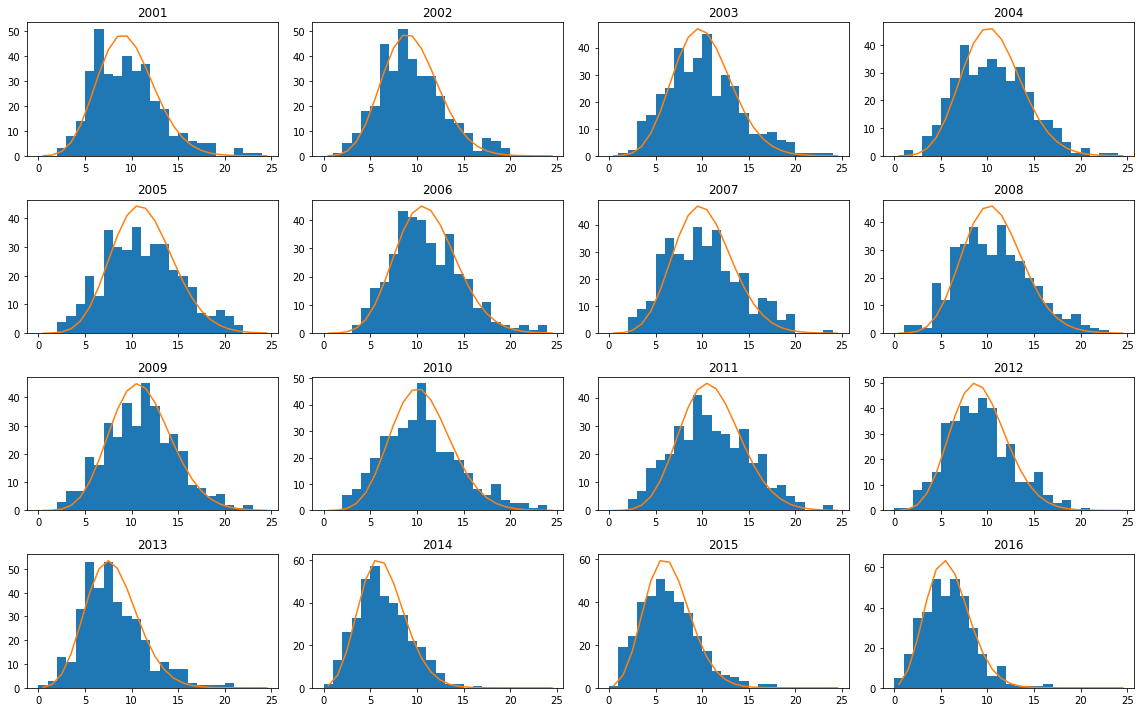

In [100]:
def pois(lam, t):
    t = int(t)
    out = 1
    for x in range(1, t+1):
        out = out * lam / x
    return out

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,10))

side = "South"
for ax, year in zip(axes.flatten(), range(2001, 2017)):
    start = datetime.datetime(year, 1, 1)
    counts = {}
    while start.year == year:
        end = start + datetime.timedelta(days=1)
        counts[start] = sum(ts >= start and ts < end for ts in by_side[side].times_datetime())
        start = end
    ax.hist(list(counts.values()), bins=list(range(0,25,1)))
    lam = np.mean(list(counts.values()))
    x = np.arange(0, 25)
    y = np.asarray([pois(lam, t) for t in x])
    y *= np.exp(-lam) * len(counts)
    ax.plot(x+0.5, y)
    ax.set_title(str(year))
fig.tight_layout()
None

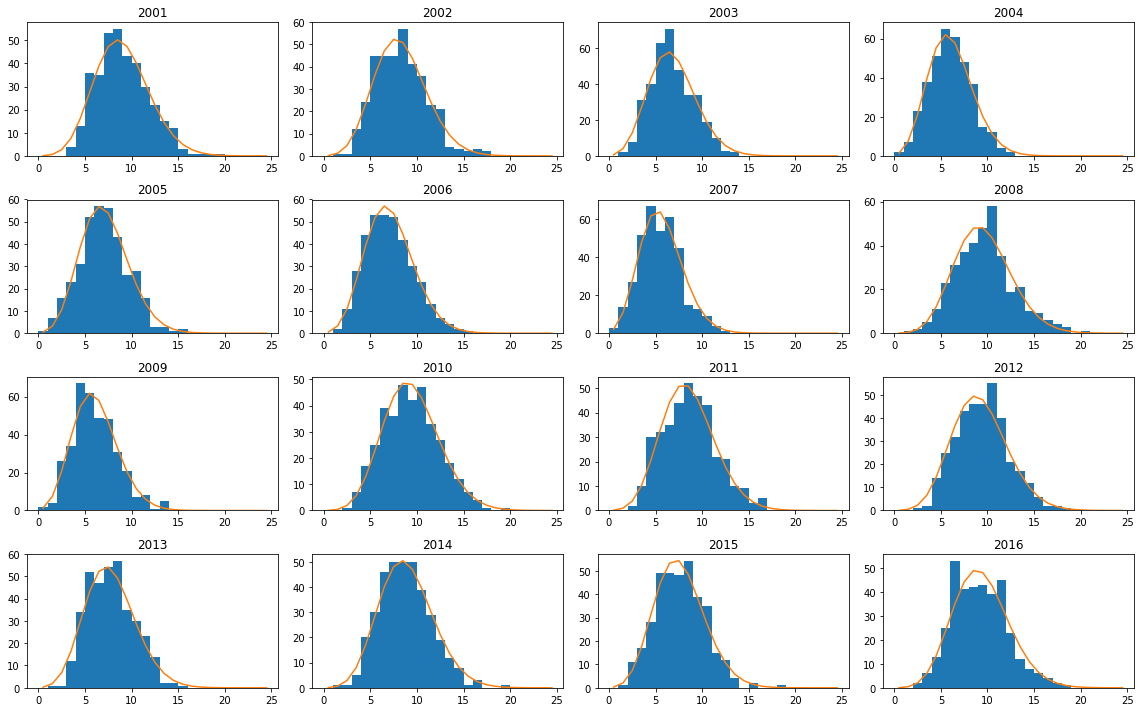

In [103]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,10))

side = "South"
for ax, year in zip(axes.flatten(), range(2001, 2017)):
    lam = np.random.random() * 5 + 5
    data = np.random.poisson(lam=lam, size=365)
    ax.hist(data, bins=list(range(0,25,1)))
    x = np.arange(0, 25)
    y = np.asarray([pois(lam, t) for t in x])
    y *= np.exp(-lam) * 365
    ax.plot(x+0.5, y)
    ax.set_title(str(year))
fig.tight_layout()
None